In [32]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt

In [2]:
# Loading data
df_crop = pd.read_parquet("data/processed/crop_annual.parquet")
df_weather = pd.read_parquet("data/processed/weather_state_month.parquet")

# Checking dtypes for merge
print(df_crop.dtypes, '\n')
print(df_weather.dtypes)

state_alpha       object
year               int64
crop              object
yield             object
area_harvested    object
dtype: object 

state          object
year            int64
month           int64
avg_temp      float64
prcp          float64
n_stations      int64
temp_Z        float64
prcp_Z        float64
dtype: object


In [3]:
# Checking for missing values
print(df_crop.isna().sum(), '\n')
print(df_weather.isna().sum(), '\n')

# Listwise deletion of empty values
df_weather.dropna(inplace=True)

# Comparing year ranges
print(df_weather['year'].max(), df_weather['year'].min())
print(df_crop['year'].max(), df_crop['year'].min())

state_alpha       0
year              0
crop              0
yield             0
area_harvested    0
dtype: int64 

state          0
year           0
month          0
avg_temp      35
prcp           8
n_stations     0
temp_Z        35
prcp_Z         8
dtype: int64 

2026 1884
2025 1961


In [4]:
df_weather.columns

Index(['state', 'year', 'month', 'avg_temp', 'prcp', 'n_stations', 'temp_Z',
       'prcp_Z'],
      dtype='object')

In [5]:
# Restricting weather df year range
df_weather = df_weather[df_weather["year"].between(1961, 2025)]

# Aggregating for annual estimates
df_weather_yearly = df_weather.groupby(["state", "year"], as_index=False).agg(
        avg_temp_yr=("avg_temp", "mean"),
        prcp_yr=("prcp", "sum"),
        temp_Z_yr=("temp_Z", "mean"),
        prcp_Z_yr=("prcp_Z", "mean"),
        n_stations_yr=("n_stations", "mean"),
    ).copy()

# Analysis

Area harvested outcome

In [6]:
w = df_weather.copy()

# Building wide tables of monthly instruments
tempZ = w.pivot_table(index=["state","year"], columns="month", values="temp_Z", aggfunc="mean")
prcpZ = w.pivot_table(index=["state","year"], columns="month", values="prcp_Z", aggfunc="mean")

# Giving names to columns based on month with prefix Z_
tempZ.columns = [f"Z_temp_m{int(m)}" for m in tempZ.columns]
prcpZ.columns = [f"Z_prcp_m{int(m)}" for m in prcpZ.columns]

Zwide = tempZ.join(prcpZ).reset_index()

# Merging weather with IVs on crop
df_Z = df_crop.merge(
    Zwide,
    left_on=["state_alpha","year"],
    right_on=["state","year"],
    how="inner"
).copy()

In [7]:
# Need to strip commas from area harvested
df_Z["area_harvested"] = df_Z["area_harvested"].astype(str).str.replace(",", "")

# Turning to numeric
df_Z['area_harvested'] = pd.to_numeric(df_Z['area_harvested'], errors='coerce')
# Taking logarithm of area harvested
df_Z["log_area"] = np.log(df_Z["area_harvested"])
# Renaming yield to crop yield
df_Z.rename(columns={"yield": 'crop_yield'}, inplace=True)
# Concatenating state ids to crop ids e.g. TX_Wheat
df_Z["entity_id"] = df_Z["state_alpha"].astype(str) + "_" + df_Z["crop"].astype(str)

# Wide IV Matrix

In [9]:
y = "log_area"
X = [c for c in df_Z.columns if c.startswith("Z_")]

df = df_Z.dropna(subset=[y] + X).copy()

dfp = df.set_index(["entity_id", "year"]).sort_index()

exog = dfp[X]
mod = PanelOLS(dfp[y], exog, entity_effects=True, time_effects=True)

res = mod.fit(cov_type="clustered", cluster_entity=True)
print(res.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:               log_area   R-squared:                        0.0244
Estimator:                   PanelOLS   R-squared (Between):             -0.0004
No. Observations:                2673   R-squared (Within):               0.0202
Date:                Thu, Jan 08 2026   R-squared (Overall):             -0.0004
Time:                        23:22:22   Log-likelihood                   -1382.5
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      2.6519
Entities:                          42   P-value                           0.0000
Avg Obs:                       63.643   Distribution:                 F(24,2543)
Min Obs:                       51.000                                           
Max Obs:                       65.000   F-statistic (robust):             4.5959
                            

# Interpretation
0.202 R - > some signal
Joint significance F=4.6 (0.00) significant

Overall R^2 close to 0, FEs doing all of the work. All explanatory power comes from FEs.

No explosive SEs. Meaningful coeffs.

Around 2% of within–state/crop variation in planted area is explained.

# LASSO Selection

In [19]:
# Generalised demeaning helper function
# Declaring helper demeaning function to re-use
def demean_2FE(df):
    # Copying dataframe
    df_fe = df.copy()
    # Looping over all columns
    for col in df.columns:
        # Grouping by FE type and and create mean vector
        e_mean = df_fe[col].groupby(level='entity_id').transform('mean')
        t_mean = df_fe[col].groupby(level='year').transform('mean')
        total_mean = df_fe[col].mean()
        # Demeaning
        df_fe[col] = df_fe[col] - e_mean - t_mean + total_mean
    return df_fe

In [35]:
y = "log_area"
Z = [c for c in df.columns if c.startswith("Z_")]

# Taking outcome and IVs and two-way demeaning
df_temp = dfp[[y] + Z].copy()
df_dm = demean_2FE(df_temp)

# Splitting demeaned outcome and regressors
y_dm = df_dm[y].values
X_dm = df_dm[Z].values

# Standardising X with scaler
scaler = StandardScaler()
X_std = scaler.fit_transform(X_dm)

# Choosing lasso coeff with CV
lasso = LassoCV(
    cv=5,
    alphas=100,
    fit_intercept=False,
    max_iter=10000,
    n_jobs=-1,
)

# Fitting LASSO
lasso.fit(X_std, y_dm)

,"eps eps: float, default=1e-3Length of the path. ``eps=1e-3`` means that``alpha_min / alpha_max = 1e-3``.",0.001
,"n_alphas n_alphas: int, default=100Number of alphas along the regularization path... deprecated:: 1.7 `n_alphas` was deprecated in 1.7 and will be removed in 1.9. Use `alphas` instead.",'deprecated'
,"alphas alphas: array-like or int, default=NoneValues of alphas to test along the regularization path.If int, `alphas` values are generated automatically.If array-like, list of alpha values to use... versionchanged:: 1.7 `alphas` accepts an integer value which removes the need to pass `n_alphas`... deprecated:: 1.7 `alphas=None` was deprecated in 1.7 and will be removed in 1.9, at which point the default value will be set to 100.",100
,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto false, no intercept will be used in calculations(i.e. data is expected to be centered).",False
,"precompute precompute: 'auto', bool or array-like of shape (n_features, n_features), default='auto'Whether to use a precomputed Gram matrix to speed upcalculations. If set to ``'auto'`` let us decide. The Grammatrix can also be passed as argument.",'auto'
,"max_iter max_iter: int, default=1000The maximum number of iterations.",10000
,"tol tol: float, default=1e-4The tolerance for the optimization: if the updates are smaller or equal to``tol``, the optimization code checks the dual gap for optimality and continuesuntil it is smaller or equal to ``tol``.",0.0001
,"copy_X copy_X: bool, default=TrueIf ``True``, X will be copied; else, it may be overwritten.",True
,"cv cv: int, cross-validation generator or iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross-validation,- int, to specify the number of folds.- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For int/None inputs, :class:`~sklearn.model_selection.KFold` is used.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: bool or int, default=FalseAmount of verbosity.",False
,"n_jobs n_jobs: int, default=NoneNumber of CPUs to use during the cross validation.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",-1


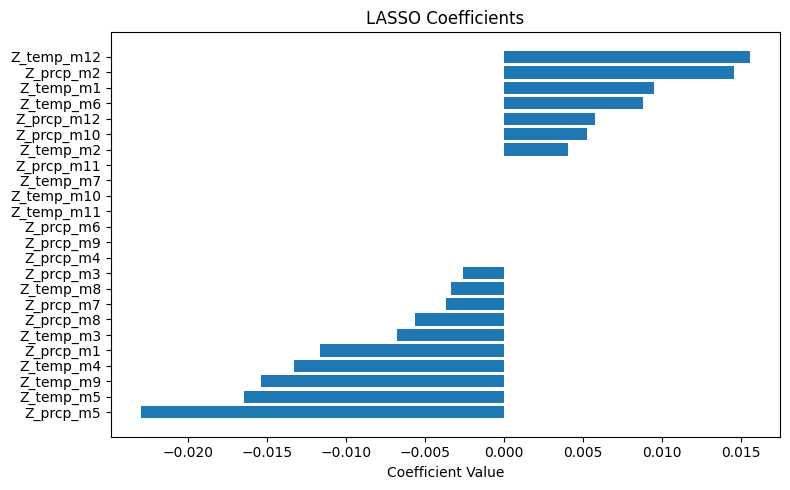

In [36]:
# Taking coefficients
coef = lasso.coef_
coef_df = pd.DataFrame({
    "variable": Z,
    "coef": coef
})

# Sorting values
coef_df = coef_df.sort_values("coef")

# Plotting
plt.figure(figsize=(8, 5))
plt.barh(coef_df["variable"], coef_df["coef"])
plt.title("LASSO Coefficients")
plt.xlabel("Coefficient Value")
plt.tight_layout()
plt.show()


In [37]:
# Extracting non-zero coefficients
selected = np.array(Z)[lasso.coef_ != 0]

print(f"Selected {len(selected)} variables:")
print(selected)

Selected 17 variables:
['Z_temp_m1' 'Z_temp_m2' 'Z_temp_m3' 'Z_temp_m4' 'Z_temp_m5' 'Z_temp_m6'
 'Z_temp_m8' 'Z_temp_m9' 'Z_temp_m12' 'Z_prcp_m1' 'Z_prcp_m2' 'Z_prcp_m3'
 'Z_prcp_m5' 'Z_prcp_m7' 'Z_prcp_m8' 'Z_prcp_m10' 'Z_prcp_m12']


# Diagnostics
Too many vars chose. Need to apply 1SE rule https://www.rob-mcculloch.org/2021_ml/webpage/notes21/1se.pdf


In [38]:
mse_mean = lasso.mse_path_.mean(axis=1)
mse_std  = lasso.mse_path_.std(axis=1)
mse_min = mse_mean.min()

idx_1se = np.where(mse_mean <= mse_min + mse_std[mse_mean.argmin()])[0][-1]

alpha_1se = lasso.alphas_[idx_1se]

lasso_1se = Lasso(
    alpha=alpha_1se,
    fit_intercept=False,
    max_iter=10000
)

lasso_1se.fit(X_std, y_dm)

selected_1se = np.array(Z)[lasso_1se.coef_ != 0]

print(f"Selected (1-SE): {len(selected_1se)}")
print(selected_1se)


Selected (1-SE): 24
['Z_temp_m1' 'Z_temp_m2' 'Z_temp_m3' 'Z_temp_m4' 'Z_temp_m5' 'Z_temp_m6'
 'Z_temp_m7' 'Z_temp_m8' 'Z_temp_m9' 'Z_temp_m10' 'Z_temp_m11'
 'Z_temp_m12' 'Z_prcp_m1' 'Z_prcp_m2' 'Z_prcp_m3' 'Z_prcp_m4' 'Z_prcp_m5'
 'Z_prcp_m6' 'Z_prcp_m7' 'Z_prcp_m8' 'Z_prcp_m9' 'Z_prcp_m10' 'Z_prcp_m11'
 'Z_prcp_m12']


Monthly weather variables are highly correlated so LASSO canot yield a sparse solution. We next try to estimate robust predictors using **stability selection across subsamples.**

The main idea is that a variable that is important to the model will be chosen consistently across subsamples

In [44]:
from collections import Counter

years = dfp.index.get_level_values("year").unique()
Z = [c for c in dfp.columns if c.startswith("Z_")]

selection_counts = Counter()
n_runs = 50

for _ in range(n_runs):
    drop_years = np.random.choice(years, size=5, replace=False)
    df_sub = dfp.loc[~dfp.index.get_level_values("year").isin(drop_years)]

    df_dm = demean_2FE(df_sub[[y] + Z].dropna())
    y_dm = df_dm[y].values
    X_dm = df_dm[Z].values

    X_std = StandardScaler().fit_transform(X_dm)

    lasso = LassoCV(cv=5, fit_intercept=False, max_iter=10000).fit(X_std, y_dm)

    selected = np.array(Z)[lasso.coef_ != 0]
    selection_counts.update(selected)

freq = {k: v / n_runs for k, v in selection_counts.items()}
freq_sorted = dict(sorted(freq.items(), key=lambda x: -x[1]))

for k, v in freq_sorted.items():
    print(f"{k}: {v:.2f}")

Z_temp_m5: 0.92
Z_temp_m9: 0.92
Z_temp_m12: 0.92
Z_prcp_m2: 0.92
Z_prcp_m5: 0.92
Z_temp_m4: 0.90
Z_prcp_m1: 0.90
Z_temp_m6: 0.86
Z_temp_m1: 0.82
Z_temp_m3: 0.80
Z_prcp_m12: 0.78
Z_prcp_m8: 0.70
Z_prcp_m10: 0.64
Z_temp_m8: 0.62
Z_temp_m2: 0.58
Z_prcp_m7: 0.52
Z_prcp_m3: 0.42
Z_prcp_m4: 0.34
Z_temp_m11: 0.24
Z_temp_m10: 0.16
Z_prcp_m9: 0.16
Z_prcp_m6: 0.06
Z_prcp_m11: 0.06


In [52]:
# Dropping weaker instruments (chosen >0.8 of the time)
filtered_vars = [k for k, v in freq_sorted.items() if v >= 0.8]
print(f"We chose {len(filtered_vars)} variables")
print('Precipitation:')
print(f'{[str(v) for v in filtered_vars if 'prcp' in v]}')
print('Temperature:')
print(f'{[str(v) for v in filtered_vars if 'temp' in v]}')


We chose 10 variables
Precipitation:
['Z_prcp_m2', 'Z_prcp_m5', 'Z_prcp_m1']
Temperature:
['Z_temp_m5', 'Z_temp_m9', 'Z_temp_m12', 'Z_temp_m4', 'Z_temp_m6', 'Z_temp_m1', 'Z_temp_m3']


In [55]:
# Selecting new Z vector
Z_selected = [str(v) for v in filtered_vars]

# Re-running FE regression
df_final = dfp[[y] + Z_selected].dropna()

model = PanelOLS(
    df_final[y],
    df_final[Z_selected],
    entity_effects=True,
    time_effects=True
)

res_final = model.fit(
    cov_type="clustered",
    cluster_entity=True
)

print(res_final.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:               log_area   R-squared:                        0.0205
Estimator:                   PanelOLS   R-squared (Between):             -0.0005
No. Observations:                2673   R-squared (Within):               0.0115
Date:                Thu, Jan 08 2026   R-squared (Overall):             -0.0005
Time:                        23:55:42   Log-likelihood                   -1387.8
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      5.3566
Entities:                          42   P-value                           0.0000
Avg Obs:                       63.643   Distribution:                 F(10,2557)
Min Obs:                       51.000                                           
Max Obs:                       65.000   F-statistic (robust):             4.2637
                            

# Interpretation
We have joint significance. Slightly lower R^2, expected. Coefficients look good. FE still doing most of work

# Saving Data for Non-Linear Model Exploration

In [56]:
import json
from pathlib import Path

OUT = Path("data/processed")
OUT.mkdir(exist_ok=True)

# Saving LASSO-selected variables
final = {
    "y": y,
    "entity_level": dfp.index.names[0],
    "time_level": "year",
    "Z_selected": [str(v) for v in Z_selected],
}

with open(OUT / "final.json", "w") as f:
    json.dump(final, f, indent=2)

# Resetting dfp multi-index
df_save = dfp[[y] + final["Z_selected"]].dropna().reset_index()

# Saving to parquet
df_save.to_parquet(OUT / "bfs_data.parquet", index=False)